## Working with a 3D large eddy simulation of shallow convection

### The simulation

* Objective: compare a single column of a GCM with large eddy simlations for three different cloud types (stratus, stratocumulus, trade cumulus)

[GCM paper](http://ezproxy.library.ubc.ca/login?url=http://doi.wiley.com/10.1002/jame.v5.4)

[LES paper](http://ezproxy.library.ubc.ca/login?url=http://doi.wiley.com/10.1002/jame.20025)

* We started with the trade cumulus simulation, then perturbed it by raising the temperature to 300 K and 301 K.

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_ctl_s6_synthetic_albedo.mp4

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_sst_300K_synthetic_albedo.mp4

http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/cgils_sst_301K_synthetic_albedo.mp4


###  The dataset  -- netccdf

[An example of reading a netCDF4 file ](http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html)


In [1]:
import glob
from netCDF4 import Dataset
from a405utils.ncdump import ncdump
from a405utils.download import download_file


download = False
if download:
    #
    #  satelite data for day 127 of 2014  Modis Aqua level 3 cloud data
    #
    url = 'http://clouds.eos.ubc.ca/~phil/Downloads/a405/ENT_CGILS_CTL_S6_3D_384x384x194_25m_1s_96_0000014160.nc'
    local_file = download_file(url)
    print('downloaded {}'.format(local_file))
    
the_file = glob.glob("*CTL*")[0]
with Dataset(the_file,'r') as ncin:
    ncdump(ncin)

NetCDF Global Attributes:
NetCDF dimension information:
	Name: x
		size: 384
		type: dtype('float32')
		units: 'm'
	Name: y
		size: 384
		type: dtype('float32')
		units: 'm'
	Name: z
		size: 194
		type: dtype('float32')
		units: 'm'
		long_name: 'height'
	Name: time
		size: 1
		type: dtype('float32')
		units: 'd'
		long_name: 'time'
NetCDF variable information:
	Name: p
		dimensions: ('z',)
		size: 194
		type: dtype('float32')
		units: 'mb'
		long_name: 'pressure'
	Name: U
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'X Wind Component                                                                '
		units: 'm/s       '
	Name: V
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'Y Wind Component                                                                '
		units: 'm/s       '
	Name: W
		dimensions: ('time', 'z', 'y', 'x')
		size: 28606464
		type: dtype('float32')
		long_name: 'Z Wind Compone

### liquid water cross section at 1 km



In [2]:
def get_var(the_file,varname):
    with Dataset(the_file) as ncin:
         out=ncin.variables[varname][...]
         x = ncin.variables['x'][...]
         y = ncin.variables['y'][...]
         z = ncin.variables['z'][...]
         out = out.squeeze()  #remove the time dimension, since we only have one timestep
    return x,y,z,out
x,y,z,qn = get_var(the_file, 'QN')

In [3]:
#
#  find the index for z = 1000 meters
#

level = np.searchsorted(z, 1000)

In [4]:
#
# get the cloud liquid water at 1000 m
#
horiz_cross_sec = qn[level,:,:]
#
# find the cross section cloud fraction
#
cloud_frac=np.sum(horiz_cross_sec > 0)/horiz_cross_sec.size
print('cloud fraction: {:5.3f}'.format(cloud_frac))

cloud fraction: 0.050


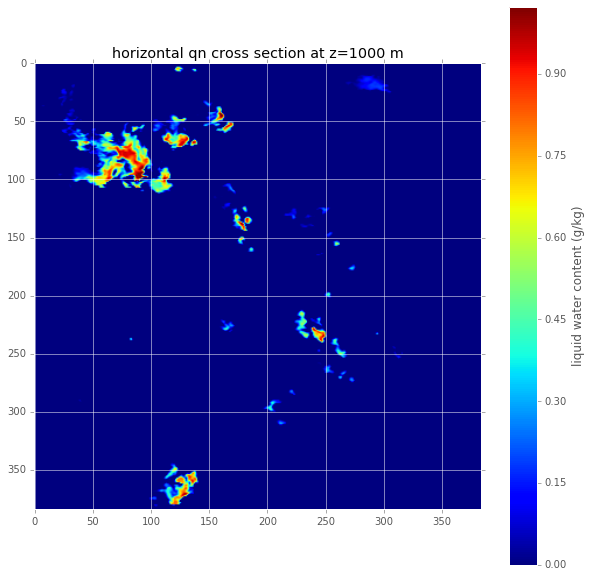

In [5]:
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot as plt
plt.close('all')
fig,ax =plt.subplots(1,1,figsize=(10,10))
whole_scene=ax.imshow(horiz_cross_sec)
cax=plt.colorbar(whole_scene,ax=ax)
cax.set_label('liquid water content (g/kg)')
title = 'horizontal qn cross section at z=1000 m'
ax.set_title(title)

### zoom in on  the top left corner

Switch from [imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) to 
[pcolormesh](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.pcolormesh) so we can orient the axes along model x,y, and z coordinates.  Note that if y is north/south (north up), then imshow plots the image upside down.

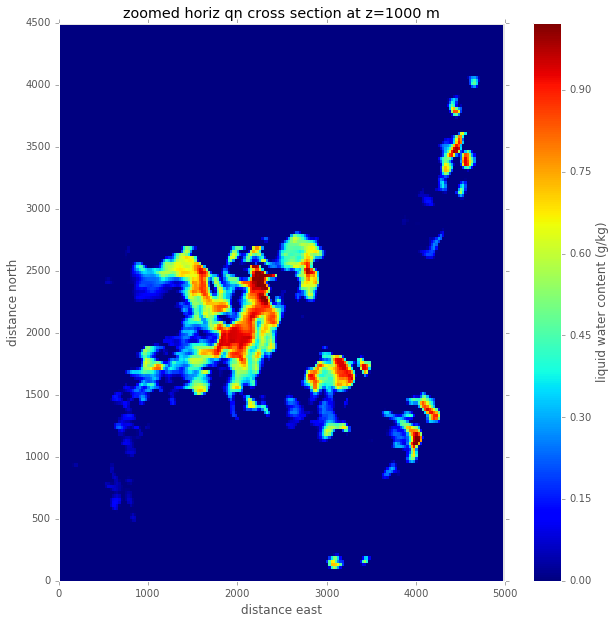

In [6]:
#
# it helps in checking your orientation to make the selection
# have different numbers of rows and columns
#
end_col = 200
end_row = 180
fig,ax =plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],y[:end_row],horiz_cross_sec[:end_row,:end_col])
ax.set(xlabel='distance east',ylabel='distance north')
cax = plt.colorbar(image,ax=ax)
cax.set_label('liquid water content (g/kg)')
ax.set_title('zoomed horiz qn cross section at z=1000 m')

### Get a vertical cross section along y = 2km

In [7]:
row_number = np.searchsorted(y,2000)  #(y index of 80)

In [8]:
row_number

80

(194, 200)
194 200


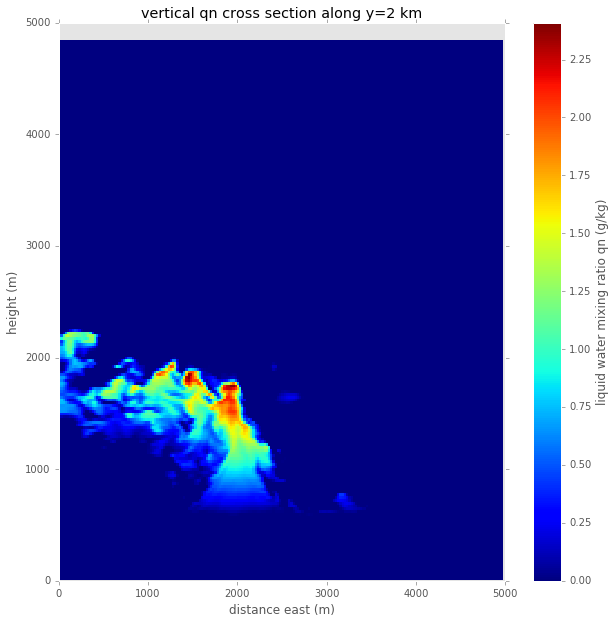

In [9]:
vert_cross_sec = qn[:,row_number,:end_col]
print(vert_cross_sec.shape)
print(len(z),len(x[:end_col]))
fig,ax = plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],z,vert_cross_sec[:,:end_col])
cax = plt.colorbar(image,ax=ax)
cax.set_label('liquid water mixing ratio qn (g/kg)')
ax.set_title('vertical qn cross section along y=2 km')
ax.set(xlabel='distance east (m)',ylabel='height (m)')

### Find the vapor mixing ratio along this cross section

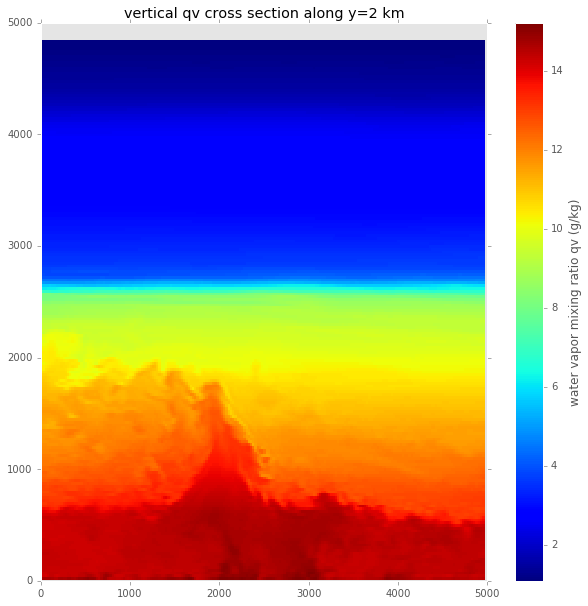

In [10]:
plt.close('all')
x,y,z,qv = get_var(the_file, 'QV')
vert_cross_sec = qv[:,row_number,:end_col]
fig,ax = plt.subplots(1,1,figsize=(10,10))
image=ax.pcolormesh(x[:end_col],z,vert_cross_sec[:,:end_col])
cax = plt.colorbar(image,ax=ax)
cax.set_label('water vapor mixing ratio qv (g/kg)')
ax.set_title('vertical qv cross section along y=2 km')

### For Monday

1\.  Read Thompkins chapter 4 parameterization notes through section 4.7.1

2\.  Read [Zhu and Randall, 1996](http://kiwi.atmos.colostate.edu/pubs/XuandRandall-semiempirical-1996.pdf)

3\.  Hand in a notebook that adds cells to cgilsI.ipynb to:

     * use pcolormesh to plot a vertical cross section of the relative humidity for along y=2 km, x= 0-5 km
     
     * use plot to plot a vertical profile of the horizontal mean RH in for this cross section as a function of height
     
     * use plot to plot a vertical profile of the horizontal standard deviation of RH as a function of height

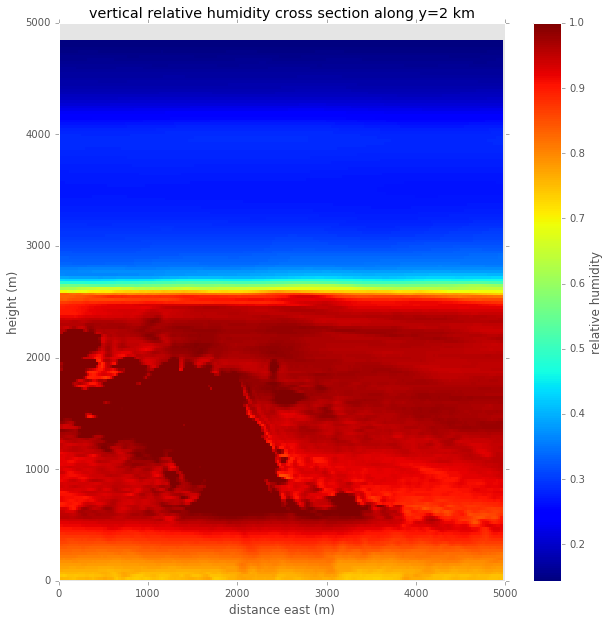

In [11]:
from a405thermo.thermlib import find_rsat
# grab variables needed for find_rsat
x,y,z,tabs = get_var(the_file, 'TABS')
x,y,z,pres = get_var(the_file, 'p') # mb = hPa
x,y,z,qv = get_var(the_file, 'QV') # g/kg

lower_x = 0
upper_x = 5000
y_val = 2000

x_ind = np.searchsorted(x,upper_x)
y_ind = np.searchsorted(y,y_val)

# temperature transect
tabs_trans = tabs[:,y_ind,0:x_ind]

# qv transect
qv_trans = qv[:,y_ind,0:x_ind]/1000. # kg/kg

# replicate 1-D pressure array into same size as tabs
pres = np.tile(pres, (tabs_trans.shape[1],1)).transpose()*100 # Pa

rsat = find_rsat(tabs_trans, pres)

# assume qv ~= rv
rh = qv_trans/rsat

fig1,ax1 = plt.subplots(1,1,figsize=(10,10))
image1=ax1.pcolormesh(x[:x_ind],z,rh)
cax1 = plt.colorbar(image1,ax=ax1)
cax1.set_label('relative humidity')
ax1.set_title('vertical relative humidity cross section along y=2 km')
ax1.set(xlabel='distance east (m)',ylabel='height (m)')

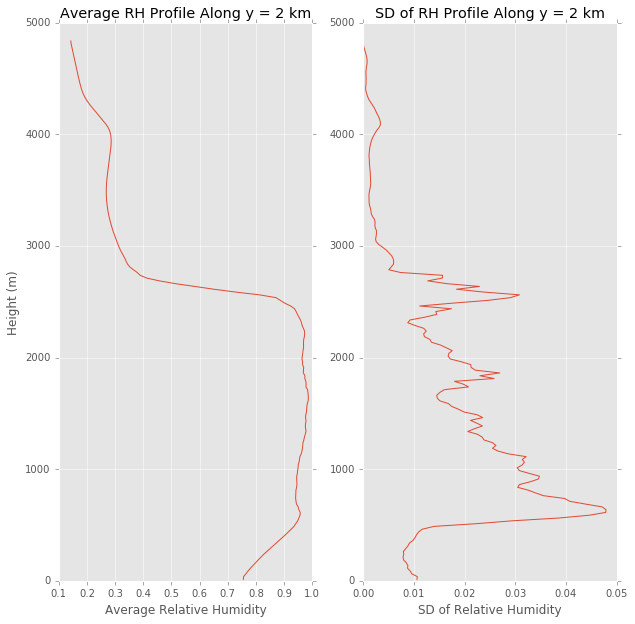

In [12]:
# get horizontal mean of rh
rh_prof = rh.mean(axis=1)

fig2,ax2 = plt.subplots(1,2,figsize=(10,10))
ax2[0].plot(rh_prof, z)
ax2[0].set_xlabel("Average Relative Humidity")
ax2[0].set_ylabel("Height (m)")
ax2[0].set_title("Average RH Profile Along y = 2 km")

# get horizontal sd of rh
rh_sd = rh.std(axis=1)
ax2[1].plot(rh_sd, z)
ax2[1].set_xlabel("SD of Relative Humidity")
ax2[1].set_title("SD of RH Profile Along y = 2 km")